# Logistic regression

In [1]:
import numpy as np
import pandas as pd
# Safe settings for Pandas.
pd.set_option('mode.chained_assignment', 'raise')
%matplotlib inline
import matplotlib.pyplot as plt
# Make the plots look more fancy.
plt.style.use('fivethirtyeight')
# Optimization function
from scipy.optimize import minimize

By Peter Rush and Matthew Brett, with considerable inspiration from the
logistic regression section of Allen Downey's book [Think Stats, second
edition](https://greenteapress.com/thinkstats2).

In this section we will look at another regression technique: logistic
regression.

We use logistic regression when we want to predict a *binary categorical*
outcome variable (or column) from one or more predicting variables (or
columns).

A binary categorical variable is one where an observation can fall into one of
only two categories. We give each observation a label corresponding to their
category.  Some examples are:

* Did a patient die or did they survive through 6 months of treatment?  The
  patient can only be in only one of the categories.  In some column of our
  data table, patients that died might have the label "died", and those who
  have survived have the label "survived".
* Did a person experience more than one episode of psychosis in the last 5
  years ("yes" or "no")?
* Did a person with a conviction for one offense offend again ("yes" or "no")?

For this tutorial, we return to the [chronic kidney disease
dataset](../data/chronic_kidney_disease).

Each row in this dataset represents one patient.

For each patient, the doctors recorded whether or not the patient had chronic
kidney disease. This is a *binary categorical variable*; you can see the
values in the "Class" column. A value of 1 means the patient *did* have CKD; a
value of 0 means they *did not*.  In this case we are labeling the categories
with numbers (1 / 0).

Many of the rest of the columns are measurements from blood tests and urine tests.

In [2]:
df = pd.read_csv('ckd_clean.csv')
df.head()

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
1,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,1
2,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,1
3,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,1
4,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,1


There are actually a large number of binary categorical variables in this
dataset.   For example, the "Hypertension" column has labels for the two
categories "yes" (the patient had persistently high blood pressure) or "no".

The categorical variable we are interested in here is "Appetite".  This has
the label "good" for patients with good appetite, and "poor" for those with
poor appetite.  Poor appetite is a [symptom of chronic kidney
disease](https://www.sciencedirect.com/science/article/abs/pii/S0270929508001666).  In our case, we wonder whether the extent of kidney damage does a convincing job in predicting whether the patient has a "good" appetite.

As you remember, the CKD dataset has a column "Hemoglobin" that has the
concentration of hemoglobin from a blood sample.  Hemoglobin is the molecule
that carries oxygen in the blood; it is the molecule that makes the red blood
cells red.  Damaged kidneys produce lower concentrations of the hormone that
stimulates red blood cell production,
[erythropoietin](https://en.wikipedia.org/wiki/Erythropoietin), so CKD
patients often have fewer red blood cells, and lower concentrations of
Hemoglobin.  We will take lower "Hemoglobin" as a index of kidney damage.
Therefore, we predict that patients with lower "Hemoglobin" values are more
likely to have `poor` "Appetite" values, and, conversely, patients with higher
"Hemoglobin" values are more likely to have `good` "Appetite" values.

First we make a new data frame that just has the two columns we are interested
in:

In [3]:
hgb_app = df.loc[:, ['Hemoglobin', 'Appetite']].copy()
hgb_app.head()

,Hemoglobin,Appetite
0,11.2,poor
1,9.5,poor
2,10.8,poor
3,5.6,poor
4,7.7,poor


## Dummy Variables

We will soon find ourselves wanting to do calculations on the values in the
"Appetite" column, and we cannot easily do that with the current string values
of "good" and "poor".   Our next step is to recode the string values to
numbers, ready for our calculations.  We use 1 to represent "good" and 0 to
represent "poor".  This kind of recoding, where we replace category labels
with 1 and 0 values, is often called *dummy coding*.

In [4]:
# 'replace' replaces the values in the first argument with the corresponding
# values in the second argument.
hgb_app['appetite_dummy'] = hgb_app['Appetite'].replace(
    ['poor', 'good'],
    [0, 1])
hgb_app.head()

,Hemoglobin,Appetite,appetite_dummy
0,11.2,poor,0
1,9.5,poor,0
2,10.8,poor,0
3,5.6,poor,0
4,7.7,poor,0


*Note*: When you are doing this, be sure to keep track of which label you have
coded as 1. Normally this would be the more interesting outcome.  In this
case, "good" has the code 1. Keep track of the label corresponding to 1, as it
will affect the interpretation of the regression coefficients.

Now we have the dummy (1 or 0) variable, let us use a scatter plot to look at
the relationship between hemoglobin concentration and whether a patient has a
good appetite.

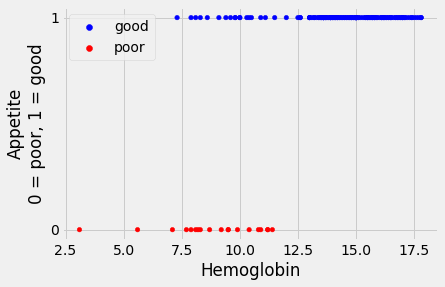

In [5]:
# We will use this plotting code several times, so put into a function for
# later use.

def plot_hgb_app():
    # Build plot, add custom labels.
    colors = hgb_app['Appetite'].replace(['poor', 'good'], ['red', 'blue'])
    hgb_app.plot.scatter('Hemoglobin', 'appetite_dummy', c=colors)
    plt.ylabel('Appetite\n0 = poor, 1 = good')
    plt.yticks([0,1]);  # Just label 0 and 1 on the y axis.
    # Put a custom legend on the plot.  This code is a little obscure.
    plt.scatter([], [], c='blue', label='good')
    plt.scatter([], [], c='red', label='poor')

# Do the plot
plot_hgb_app()
# Show the legend
plt.legend();

From the plot, it does look as if the patients with lower hemoglobin are more
likely to have poor appetite (`appetite_dummy` values of 0), whereas patients
with higher hemoglobin tend to have good appetite (`appetite_dummy` values of
1).

Now we start to get more formal, and develop a model with which we predict the
`appetite_dummy` values from the  `Hemoglobin` values.


## How about linear regression?

Remember that, in linear regression, we predict scores on the *outcome*
variable (or column) using a straight-line relationship of the *predictor*
variable (or column).

Here are the predictor and outcome variables in our case.

In [6]:
# The x (predictor) and y (outcome) variables.
hemoglobin = hgb_app['Hemoglobin']
appetite_d = hgb_app['appetite_dummy']

Why not use the same linear regression technique for our case?  After all, the
`appetite_d` values are just numbers (0 and 1), as are our `hemoglobin` values.

Earlier in the textbook, we performed linear regression by using `minimize`, to
find the value of the slope and intercept of the line which gives the smallest
sum of the squared prediction errors.

Recall that, in linear regression:

$$
\text{predicted} = intercept + slope * \text{predictor_variable}
$$

*predicted* and *predictor variable* here are sequences of values, with one
value for each observation (row) in the dataset. In our case we have:

In [7]:
print('Rows in CKD data', len(hgb_app))

Rows in CKD data 158


"observations" (patients), so there will be the same number of scores on the
predictor variable (`hemoglobin`), and the same number of predictions, in
`predicted`. By contrast, the slope and intercept are single values, defining
the line.

We used `minimize` to find the values of the slope and intercept which give the
"best" predictions.  So far, we have almost invariably defined the *best*
values for slope and intercept as the values that give the smallest sum of the
squared prediction errors.

$$
\text{prediction errors} = \text{actual variable - predicted}
$$

What would happen if we tried to use linear regression to predict the
probability of having good appetite, based on hemoglobin concentrations?

Let us start by grabbing a version of the `ss_any_line` function from the
[Using minimize page](../mean-slopes/using_minimize.html).

In [8]:
def ss_any_line(c_s, x_values, y_values):
    # c_s is a list containing two elements, an intercept and a slope.
    intercept, slope = c_s
    # Values predicted from these x_values, using this intercept and slope.
    predicted = intercept + x_values * slope
    # Difference of prediction from the actual y values.
    error = y_values - predicted
    # Sum of squared error.
    return np.sum(error ** 2)

The sum of squared prediction error, in linear regression, is our *cost*
function. When we have a good pair of (intercept, slope) in `c_s`, our function
is *cheap* - i.e. the returned value is small.  When we have a bad pair in
`c_s`, our function is *expensive* - the returned value is large.

If the value from `ss_any_line` is large, it means the line we are fitting does
not fit the data well. The purpose of linear regression is to find the
line which leads to the smallest cost.  In our case, the cost is the sum of the
squared prediction errors.

Let's use linear regression on the current example.  From looking at our plot above, we start with a guess of -1 for the intercept, and 0.1 for the slope.

In [9]:
# Use minimize to find the least sum of squares solution.
min_lin_reg = minimize(ss_any_line, [-1, 0.1], args=(hemoglobin, appetite_d))
# Show the results that came back from minimize.
min_lin_reg

      fun: 10.315509522411862
 hess_inv: array([[ 0.07498683, -0.00524735],
       [-0.00524735,  0.00038337]])
      jac: array([-7.39097595e-06,  5.13792038e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 104
      nit: 2
     njev: 31
   status: 2
  success: False
        x: array([-0.07904187,  0.0700493 ])

OK, so that looks hopeful. Using linear regression with `minimize` we found that the sum of squared prediction errors was smallest for a line with:

In [10]:
# Unpack the slope and intercept estimates from the results object.
lin_reg_intercept, lin_reg_slope = min_lin_reg.x
# Show them.
print('Best linear regression intercept', lin_reg_intercept)
print('Best linear regression slope', lin_reg_slope)

Best linear regression intercept -0.07904187280281949
Best linear regression slope 0.07004929869481377


The linear regression model we are using here is:

```
predicted_appetite_d = intercept + slope * hemoglobin
```

Specifically:

In [11]:
predicted_lin_reg = lin_reg_intercept + lin_reg_slope * hemoglobin
predicted_lin_reg

0      0.705510
1      0.586426
2      0.677491
3      0.313234
4      0.460338
         ...   
153    1.020732
154    1.076772
155    1.027737
156    0.915658
157    1.027737
Name: Hemoglobin, Length: 158, dtype: float64

Let's plot our predictions, alongside the actual data.  We plot the predictions
from linear regression in orange.

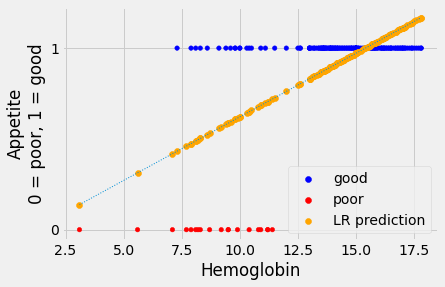

In [12]:
# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()

# A new plot on top of the old.
plt.scatter(hemoglobin, predicted_lin_reg,
            label='LR prediction',
            color='orange')
# Another plot, to show the underlying line
fine_x = np.linspace(np.min(hemoglobin), np.max(hemoglobin), 1000)
fine_y = lin_reg_intercept + lin_reg_slope * fine_x
plt.plot(fine_x, fine_y, linewidth=1, linestyle=':')
# Show the legend.
plt.legend();

The linear regression line looks plausible, as far as it goes, but it has
several unhappy features for our task of predicting the `appetite_d` 0 / 1
values.

One thing to like about the line is that the predictions are right to suggest
that the value of `appetite_d` is more likely to be 1 (meaning "good") at
higher values of `hemoglobin`.  Also, the prediction line slopes upward as
`hemoglobin` gets higher, indicating that the probability of good appetite gets
higher as the hemoglobin concentration rises, across patients.

However, when the `hemoglobin` gets higher than about 15.5, linear regression
starts to predict a value for `appetite_d` that is greater than 1 - which, of
course, cannot occur in the `appetite_d` values, which are restricted to 0 or
1.

Looking at the plot, without the regression line, it looks as if we can be
fairly confident of predicting a 1 ("good") value for a hemoglobin above 12.5, but we are increasingly less confident about predicting a 1 value as hemoglobin drops down to about 7.5, at which point we become confident about predicting a 0 value.

These reflections make as wonder whether we should be using something other
than a simple, unconstrained straight line for our predictions.


## Another prediction line

Here's another prediction line we might use for `appetite_d`, with the
predicted values.

For the moment, please don't worry about how we came by this line, we will come
onto that soon.

The new prediction line is in gold.

In [13]:
# This is the machinery for making the sigmoid line of the plots below.  We
# will come on that machinery soon.  For now please ignore this code, and
# concentrate on the plots below.

def inv_logit(y):
    """ Reverse logit transformation
    """
    odds_ratios = np.exp(y)  # Reverse the log operation.
    return odds_ratios / (odds_ratios + 1)  # Reverse odds ratios operation.


def params2pps(intercept, slope, x):
    """ Calculate predicted probabilities of 1 for each observation.
    """
    # Predicted log odds of being in class 1.
    predicted_log_odds = intercept + slope * x
    return inv_logit(predicted_log_odds)


# Some plausible values for intercept and slope.
nice_intercept, nice_slope = -7, 0.8
predictions_new = params2pps(nice_intercept, nice_slope, hemoglobin)

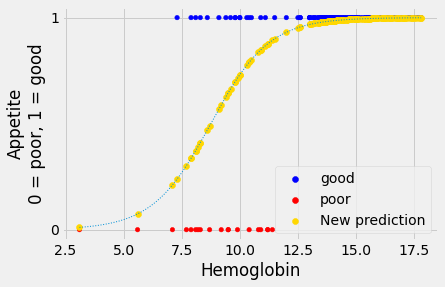

In [14]:
# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()

# A new plot on top of the old.
plt.scatter(hemoglobin, predictions_new,
            label='New prediction',
            color='gold')
# Another plot, to show the underlying line
fine_y_sigmoid = params2pps(nice_intercept, nice_slope, fine_x)
plt.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
# Show the legend.
plt.legend();

The new not-straight line seems to have much to recommend it.  This shape of
line is called "sigmoid", from the name of the Greek letter "s".  The sigmoid
prediction here never goes above 1 or below 0, so its values are always in the
range of the `appetite_d` data it is trying to predict.  It climbs steeply to a
prediction of 1, and plateaus there, as we get to the threshold of hemoglobin
around 12.5, at which every patient does seem to have "good" appetite
(`appetite_d` of 1).

We can think of the values from the sigmoid curve as being *predicted
probabilities*.  For example, at a `hemoglobin` value of 10, the curve gives a
predicted y (`appetite_d`) value of about 0.73.  We can interpret this
prediction as saying that, with a hemoglobin value of 10, there is a
*probability* of about 0.73 that the corresponding patient will have a "good"
appetite (`appetite_d` value of 1).

Now let us say that we would prefer to use this kind of sigmoid line to predict
`appetite_d`.  So far, we have only asked `minimize` to predict directly from a
straight line - for example, in the `ss_any_line` function.   How can we get
minimize to predict from a family of sigmoid curves, as here?  Is there a way
of transforming a sigmoid curve like the one here, with y values from 0 to 1,
to a straight line, where the y values can vary from large negative to large
positive?  We would like to do such a conversion, so we have a slope and
intercept that `minimize` can work with easily.

The answer, you can imagine, is "yes" — we can go from our sigmoid 0 / 1 curve
to a straight line with unconstrained y values, in two fairly simple steps. The
next sections will cover those steps.  The two steps are:

* Convert the 0 / 1 *probability* predictions to 0-to-large positive
  predictions of the *odds ratio*.  The odds-ratio can vary from 0 to very
  large positive.
* Apply the *logarithm* function to convert the 0-to-very-large-positive
  odds-ratio predictions to log odds-ratio predictions, which can vary from
  very large negative to very large positive.

These two transformations together are called the *log-odds* or
[logit](https://en.wikipedia.org/wiki/Logit) transformation.  *Logistical
regression* is regression using the *logit* transform.  Applying the logit
transform converts the sigmoid curve to a straight line.

We will explain more about the two stages of the transform below, but for now, here are the two stages in action.

This is the original sigmoid curve above, with the predictions, in its own
plot.

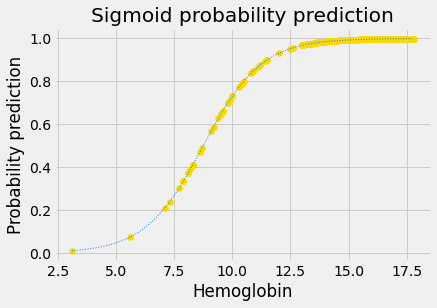

In [15]:
plt.scatter(hemoglobin, predictions_new, color='gold')
plt.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
plt.title('Sigmoid probability prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction');

Next we apply the conversion from probability to odds-ratio:

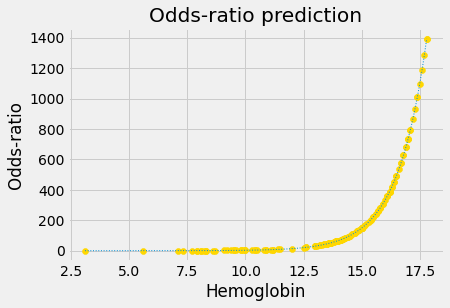

In [16]:
predictions_or = predictions_new / (1 - predictions_new)
plt.scatter(hemoglobin, predictions_or, color='gold')
fine_y_or = fine_y_sigmoid / (1 - fine_y_sigmoid)
plt.plot(fine_x, fine_y_or, linewidth=1, linestyle=':')
plt.title('Odds-ratio prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Odds-ratio');

Notice that this is an *exponential* graph, where the y values increase more
and more steeply as the x values increase.  We can turn exponential lines like
this one into straight lines, using the *logarithm* function, the next stage of
the logit transformation:

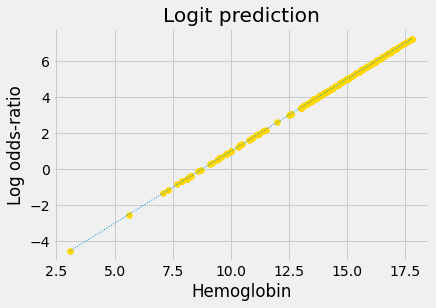

In [17]:
predictions_or_log = np.log(predictions_or)
plt.scatter(hemoglobin, predictions_or_log, color='gold')
fine_y_or_log = np.log(fine_y_or)
plt.plot(fine_x, fine_y_or_log, linewidth=1, linestyle=':')
plt.title('Logit prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Log odds-ratio');

Now we have a straight line, with an intercept and slope, suitable for
`minimize`.  The next few sections go into more detail on the odds-ratio and
logarithm steps.

## Probability and Odds

For logistic regression, in contrast to linear regression, we are interested in
predicting the *probability of an observation falling into a particular outcome
class* (0 or 1).

In this case, we are interested in the probability of a patient having "good"
appetite, predicted from the patient's hemoglobin.

We can think of probability as the *proportion of times* we expect to see a
particular outcome.

For example, there are 139 patients with "good" appetite in this data frame,
and 158 patients in total.  If you were to repeatedly draw a single patient at
random from the data frame, and record their `Appetite`, then we expect the proportion of "good" values in the long run, to be 139 / 158 --- about 0.88.  That is the same as saying there is a probability of 0.88 of a randomly-drawn patient of having a "good" appetite.

Because the patient's appetite can only be "good" or "poor", and because the
probabilities of all possible options have to add up to 1, the probability of
the patient having a "poor" appetite is 1 - 0.88 --- about 0.12.

So, the probability can express the *proportion of times* we expect to see some
*event of interest* - in our case, the event of interest is "good" in the
`Appetite` column.

We can think of this same information as an *odds ratio*.

We often express probabilities as odds ratios.  For example, we might say that
the odds are 5 to 1 that it will rain today.   We mean that it is five times
more likely that it will rain today than that it will not rain today.   On
another day we could estimate that the odds are 0.5 to 1 that it will rain
today, meaning that it is twice as likely *not* to rain, as it is to rain.

The odds ratio is the number of times we expect to see the event of interest
(e.g. rain) for every time we expect to see the event of no interest (not
rain).

This is just a way of saying a probability in a different way, and we can convert easily between probabilities and odds ratios.

To convert from a probability to an odds ratio, we remember that the odds ratio is the number of times we expect to see the event of interest for every time we expect to see the event of no interest.   This is the probability (proportion) for the event of interest, divided by the probability (proportion) of the event of no interest.  Say the probability p is some value (it could be any value):

In [18]:
# Our proportion of interest.
p = 0.88

Then the equivalent odds ratio `odds_ratio` is:

In [19]:
# Odds ratio is proportion of interest, divided by proportion of no interest.
odds_ratio = p / (1 - p)
odds_ratio

7.333333333333334

Notice the odds ratio is greater than one, because `p` was greater than 0.5. An
odds ratio of greater than one means the event of interest is more likely to
happen than the alternative.  An odds ratio of less than one means p was less
than 0.5, and the event of interest is less likely to happen than the
alternative.   A p value of 0 gives an odds ratio of 0.  As the p value gets close to 1, the odds ratio gets very large.

In [20]:
p = 0.999999
p / (1 - p)

999998.9999712444

We can also convert from odds ratios to p values.  Remember the odds ratio is
the number of times we expect to see the event of interest, divided by the
number of times we expect to see the event of no interest.  The probability is
the proportion of all events that are events of interest.  We can read an
`odds_ratio` of - say - 2.5 as "the chances are 2.5 to 1".  To get the
probability we divide the number of times we expect to see the event of
interest - here 2.5 - by the number of events in total.  The number of events
in total is just the number of events of interest - here 2.5 - plus the number
of events of no interest - here 1.  So:

In [21]:
p_from_odds_ratio = odds_ratio / (odds_ratio + 1)
p_from_odds_ratio

0.88

Summary - convert probabilities to odds ratios with:

In [22]:
odds_ratio = p / (1 - p)

Convert odds ratios to probabilities with:

In [23]:
p = odds_ratio / (odds_ratio + 1)

As you've seen, when we apply the conversion above, to convert the probability values to odds ratios for our appetite predications, we get the following:

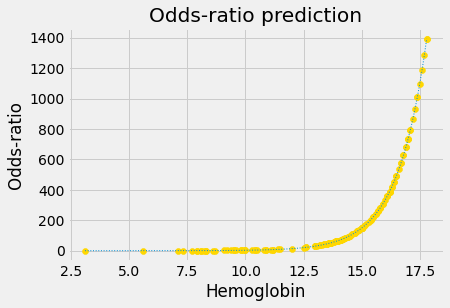

In [24]:
predictions_or = predictions_new / (1 - predictions_new)
plt.scatter(hemoglobin, predictions_or,
            color='gold')
fine_y_or = fine_y_sigmoid / (1 - fine_y_sigmoid)
plt.plot(fine_x, fine_y_or, linewidth=1, linestyle=':')
plt.title('Odds-ratio prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Odds-ratio');

Notice that the odds ratios we found vary from very close to 0 (for p value
predictions very close to 0) to very large (for p values very close to 1).

Notice too that our graph looks exponential, and we want it to be a straight
line.   Our next step is to apply a *logarithm* transformation.

## The logarithm transform

See the [logarithm refresher](logarithms_refreshed) page for more background on
logarithms.

For now, the only thing you need to know about logarithms is that they are
transformations that convert an exponential curve into a straight line.

Here's an example:

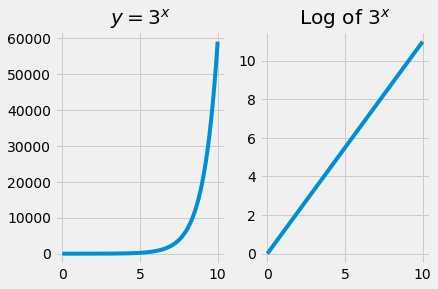

In [25]:
x = np.linspace(0, 10, 1000)
y = 3 ** x
fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
ax0.plot(x, y)
ax0.set_title(r'$y=3^x$')
ax1.plot(x, np.log(y))
ax1.set_title(r'Log of $3^x$');

You have already see logs in action transforming the odds-ratio predictions.

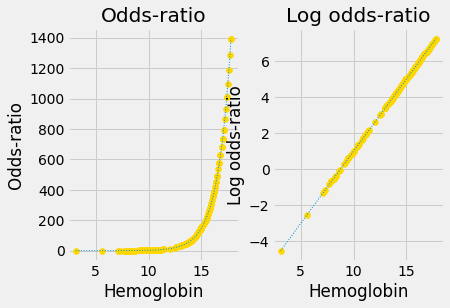

In [26]:
fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
ax0.scatter(hemoglobin, predictions_or, color='gold')
ax0.plot(fine_x, fine_y_or, linewidth=1, linestyle=':')
ax0.set_title('Odds-ratio')
ax0.set_xlabel('Hemoglobin')
ax0.set_ylabel('Odds-ratio');
ax1.scatter(hemoglobin, predictions_or_log, color='gold')
ax1.plot(fine_x, fine_y_or_log, linewidth=1, linestyle=':')
ax1.set_title('Log odds-ratio')
ax1.set_xlabel('Hemoglobin')
ax1.set_ylabel('Log odds-ratio');

## The logit transform and its inverse

The logit transformation from the sigmoid curve to the straight line consists
of two steps:

* Convert probability to odd-ratios.
* Take the log of the result.

The full logit transformation is therefore:

In [27]:
def logit(p):
    """ Apply logit transformation to array of probabilities `p`
    """
    odds_ratios = p / (1 - p)
    return np.log(odds_ratios)

Here are the original sigmoid predictions and the predictions with the `logit` transform applied:

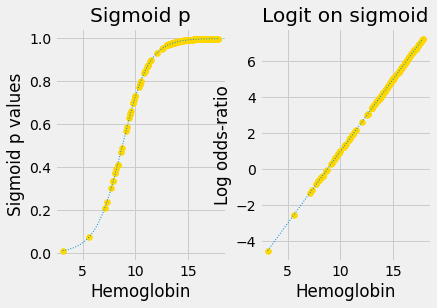

In [28]:
fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
ax0.scatter(hemoglobin, predictions_new, color='gold')
ax0.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
ax0.set_title('Sigmoid p')
ax0.set_xlabel('Hemoglobin')
ax0.set_ylabel('Sigmoid p values');
ax1.scatter(hemoglobin, logit(predictions_new), color='gold')
ax1.plot(fine_x, logit(fine_y_sigmoid), linewidth=1, linestyle=':')
ax1.set_title('Logit on sigmoid')
ax1.set_xlabel('Hemoglobin')
ax1.set_ylabel('Log odds-ratio');

We also want to be able to go backwards, from the straight-line predictions, to
the sigmoid predictions.

`np.exp` reverses (inverts) the `np.log` transformation (see the [logarithm
refresher](logarithms_refreshed) page):

In [29]:
# np.exp reverses the effect of np.log.
some_values = np.array([1, 0.5, 3, 6, 0.1])
values_back = np.exp(np.log(some_values))
values_back

array([1. , 0.5, 3. , 6. , 0.1])

You have seen above that there is a simple formula to go from odds ratios to
probabilities.  The transformation that *reverses*  (inverts) the logit
transform is therefore:

In [30]:
def inv_logit(v):
    """ Reverse logit transformation on array `v`
    """
    odds_ratios = np.exp(v)  # Reverse the log operation.
    return odds_ratios / (odds_ratios + 1)  # Reverse odds ratios operation.

`inv_logit` takes points on a straight line, and converts them to points on a
sigmoid.

First we convince ourselves that `inv_logit` does indeed reverse the `logit`
transform:

In [31]:
some_p_values = np.array([0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99])
some_log_odds = logit(some_p_values)
back_again = inv_logit(some_log_odds)
print('Logit, then inv_logit returns the original data', back_again)

Logit, then inv_logit returns the original data [0.01 0.05 0.1  0.5  0.9  0.95 0.99]


The plot above has the sigmoid curve p-value predictions, and the p-value
predictions with the logit transformation applied.

Next you see the logit-transformed results on the left.  The right shows the
results of applying `inv_logit` to recover the original p values.

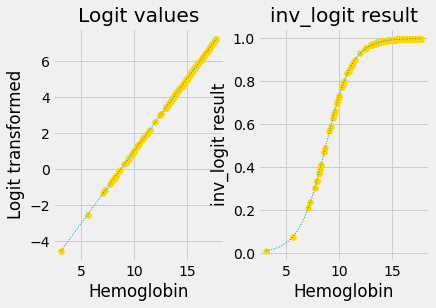

In [32]:
fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
ax0.scatter(hemoglobin, predictions_or_log, color='gold')
ax0.set_title('Logit values')
ax0.set_xlabel('Hemoglobin')
ax0.set_ylabel('Logit transformed');
ax0.plot(fine_x, fine_y_or_log, linewidth=1, linestyle=':')
ax1.scatter(hemoglobin, predictions_new,
            color='gold')
ax1.set_title('inv_logit result')
ax1.set_xlabel('Hemoglobin')
ax1.set_ylabel('inv_logit result');
ax1.plot(fine_x, inv_logit(fine_y_or_log), linewidth=1, linestyle=':');

## Effect of the Logit slope and intercept on the sigmoid

Changing the intercept of the logit (log-odds) straight line moves the
corresponding inverse logit sigmoid curve left and right on the horizontal
axis:

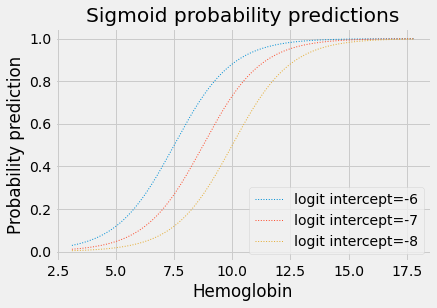

In [33]:
for intercept in [-6, -7, -8]:
    plt.plot(fine_x,
            params2pps(intercept, 0.8, fine_x),
            linewidth=1,
            linestyle=':',
            label='logit intercept=%d' % intercept)
plt.title('Sigmoid probability predictions')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction')
plt.legend();

Changing the slope of the logit straight line makes the transition from 0 to 1
flatter or steeper:

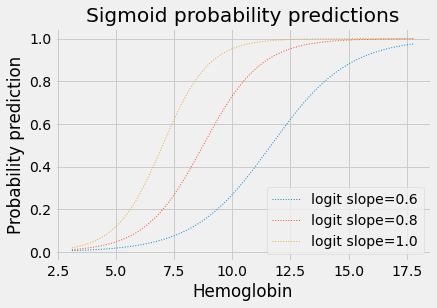

In [34]:
for slope in [0.6, 0.8, 1.0]:
    plt.plot(fine_x,
            params2pps(-7, slope, fine_x),
            linewidth=1,
            linestyle=':',
            label='logit slope=%.1f' % slope)
plt.title('Sigmoid probability predictions')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction')
plt.legend();

## A first-pass at logistic regression

You may now see how we could use `minimize` with a slope and intercept.

Remember that `minimize` needs a *cost function* that takes some parameters -
in our case, the intercept and slope — and returns a score, or cost for the
parameters.

In the `ss_any_line` cost function above, the score it returns is just the sum
of squared prediction errors from the line.  But the cost function can do
anything it likes to generate a score from the line.

In our case, we're going to make a cost function that takes the intercept and
slope, and generates predictions using the intercept and slope and `hemoglobin`
values.  But these predictions are for the log-odds transformed values, on the
straight line.  So the cost function then converts the predictions into p value
predictions, on the corresponding sigmoid, and compares these predictions to the 0 / 1 values in `appetite_d`.

For example, let's say we want to get a score for the intercept -7 and the
slope 0.8.

First we get the straight-line predictions in the usual way:

Text(0, 0.5, 'Straight-line (log-odds) predictions')

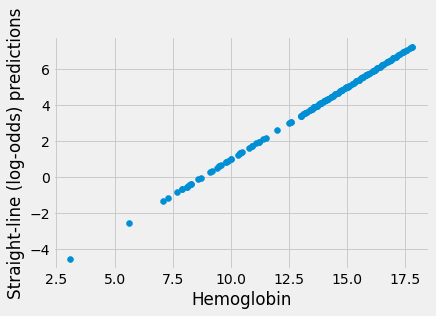

In [35]:
intercept, slope = -7, 0.8
sl_predictions = intercept + slope * hemoglobin

plt.scatter(hemoglobin, sl_predictions)
plt.xlabel('Hemoglobin')
plt.ylabel('Straight-line (log-odds) predictions')

These are predictions on the straight line, but we now need to transform them
to p value (0 to 1) predictions on the sigmoid.  We use `inv_logit`:

Text(0, 0.5, 'Sigmoid (p-value) predictions')

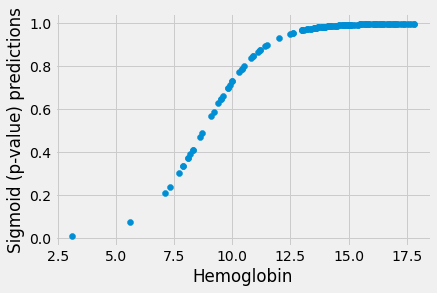

In [36]:
sigmoid_predictions = inv_logit(sl_predictions)

plt.scatter(hemoglobin, sigmoid_predictions)
plt.xlabel('Hemoglobin')
plt.ylabel('Sigmoid (p-value) predictions')

Finally, we want to compare the predictions to the actual data to get a score.
One way we could do this is our good old sum of squares difference between the
sigmoid p-value predictions and the 0 / 1 values:

In [37]:
sigmoid_error = appetite_d - sigmoid_predictions
sigmoid_score = np.sum(sigmoid_error ** 2)
sigmoid_score

10.044653157567184

Next we make the cost function that minimize will use.  It must accept an array
of parameters (an intercept and slope), and calculate the sum of squares error,
using the predicted p-values:

In [38]:
def ss_logit(c_s, x_values, y_values):
    # Unpack intercept and slope into values.
    intercept, slope = c_s
    # Predicted values for log-odds straight line.
    predicted_log_odds = intercept + slope * x_values
    # Predicted p values on sigmoid.
    pps = inv_logit(predicted_log_odds)
    # Prediction errors.
    sigmoid_error = y_values - pps
    # Sum of squared error
    return np.sum(sigmoid_error ** 2)

We check our function gives the same results as the step-by-step calculation above.

In [39]:
ss_logit([-7, 0.8], hemoglobin, appetite_d)

10.044653157567184

Notice what is happening here.  The cost function gets the new intercept and
slope to try, makes the predictions from the intercept and slope, converts the
predictions to probabilities on the sigmoid, and tests those against the real
labels.

Now let's see the cost function in action:

In [40]:
min_res_logit = minimize(ss_logit, [-7, 0.8], args=(hemoglobin, appetite_d))
min_res_logit

      fun: 9.621504133676222
 hess_inv: array([[ 6.0509272 , -0.57246015],
       [-0.57246015,  0.05674741]])
      jac: array([-1.19209290e-07,  2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([-5.28090451,  0.58493981])

Does this result look like it gives more convincing sigmoid predictions than
our guessed intercept an slope of -7 and 0.8?

First get the sigmoid predictions from this line:

In [41]:
logit_ss_inter, logit_ss_slope = min_res_logit.x
# Predicted values on log-odds straight line.
predicted_log_odds = logit_ss_inter + logit_ss_slope * hemoglobin
# Predicted p values on sigmoid.
logit_ss_pps = inv_logit(predicted_log_odds)

Then plot:

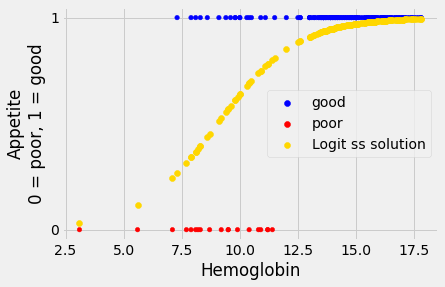

In [42]:
plot_hgb_app()
# A new plot on top of the old.
plt.scatter(hemoglobin, logit_ss_pps,
            label='Logit ss solution',
            color='gold')
# Show the legend.
plt.legend();

## A different measure of prediction error

Our sigmoid prediction from sum of squares above looks convincing enough, but,
is there a better way of scoring the predictions from our line, than sum of
squares?

It turns out there is another quite different and useful way to score the
predictions, called *likelihood*.  For reasons we discuss in [this
page](logistic_convexity), all standard implementations of logistic regression
that we know of, use the *likelihood* measure that we describe below, instead
of the sum of squares measure you see above.

Likelihood asks the question: assuming our predicting line, how likely are the
sequence of actual 0 / 1 values that we see?

To answer this question, we first ask this question about the individual 0 / 1
values.

We start with our intercept of -7 and slope of 0.8 for the straight-line
log-odds values.  We generate the straight-line predictions, then convert them
to sigmoid p-value predictions.

In [43]:
log_odds_predictions = -7 + hemoglobin * 0.8
sigmoid_p_predictions = inv_logit(log_odds_predictions)

Remember, these are the predicted probabilities of a 1 label.  We rename to remind ourselves:

In [44]:
pp_of_1 = sigmoid_p_predictions

We put these predictions into a copy of our data set to make them easier to display:

In [45]:
hgb_predicted = hgb_app.copy()
hgb_predicted['pp_of_1'] = pp_of_1
hgb_predicted.head()

,Hemoglobin,Appetite,appetite_dummy,pp_of_1
0,11.2,poor,0,0.876533
1,9.5,poor,0,0.645656
2,10.8,poor,0,0.837535
3,5.6,poor,0,0.074468
4,7.7,poor,0,0.301535


Consider the last row in this data frame:

In [46]:
last_row = hgb_predicted.tail(1)
last_row

,Hemoglobin,Appetite,appetite_dummy,pp_of_1
157,15.8,good,1,0.99646


The `pp_of_1` value is the probability that we will see a label of 1 for this
observation.   The outcome was, in fact, 1.  Therefore the predicted
probability that we will see the actual value is just the corresponding
`pp_of_1` value:

In [47]:
pp_of_last_value = pp_of_1.iloc[-1]
pp_of_last_value

0.9964597097790535

Now consider the first row:

In [48]:
first_row = hgb_predicted.head(1)
first_row

,Hemoglobin,Appetite,appetite_dummy,pp_of_1
0,11.2,poor,0,0.876533


The probability for an `appetite_dummy` value of 1 is:

In [49]:
pp_of_1[0]

0.876532952434776

Because the values can only be 0 or 1, the predicted probability of an
`appetite_dummy` of 0 must be 1 minus the (predicted probability of 1):

In [50]:
pp_of_first_value = 1 - pp_of_1[0]
pp_of_first_value

0.12346704756522398

We can therefore calculate the predicted probability of each 0 / 1 label in the
data frame like this:

In [51]:
# Predicted probability of 0.
pp_of_0 = 1 - pp_of_1
# The next line sets all the label == 1 values correctly, but
# the label == 0 values are now incorrect.
pp_of_label = pp_of_1.copy()
# Set the label == 0 values correctly.
poor_appetite = appetite_d == 0
pp_of_label[poor_appetite] = pp_of_0[poor_appetite]
# Put this into the data frame for display
hgb_predicted['pp_of_label'] = pp_of_label
hgb_predicted

,Hemoglobin,Appetite,appetite_dummy,pp_of_1,pp_of_label
0,11.2,poor,0,0.876533,0.123467
1,9.5,poor,0,0.645656,0.354344
2,10.8,poor,0,0.837535,0.162465
3,5.6,poor,0,0.074468,0.925532
4,7.7,poor,0,0.301535,0.698465
...,...,...,...,...,...
153,15.7,good,1,0.996166,0.996166
154,16.5,good,1,0.997975,0.997975
155,15.8,good,1,0.996460,0.996460
156,14.2,good,1,0.987383,0.987383


There's a fancy short-cut to the several lines above, that relies on the fact
that multiplying by 0 gives 0.  We can form the `pp_of_label` column by first
multiplying the 0 / 1 label column values by the values in `pp_of_1`.  This
correctly sets the `pp_of_label` values for labels of 1, and sets the
remainder to 0. Then we reverse the 0 / 1 labels by subtracting from 1, and
multiply by `pp_of_0` to set the 0 values to their correct values.  Adding
these two results gives us the correct set of values for both 1 and 0 labels.

In [52]:
# Set label == 1 values to predicted p, others to 0
pos_ps = appetite_d * pp_of_1
# Set label == 0 values to 1-predicted p, others to 0
neg_ps = (1 - appetite_d) * pp_of_0
# Combine by adding.
final = pos_ps + neg_ps
# This gives the same result as the code cell above:
hgb_predicted['pp_of_label_fancy'] = final
hgb_predicted

,Hemoglobin,Appetite,appetite_dummy,pp_of_1,pp_of_label,pp_of_label_fancy
0,11.2,poor,0,0.876533,0.123467,0.123467
1,9.5,poor,0,0.645656,0.354344,0.354344
2,10.8,poor,0,0.837535,0.162465,0.162465
3,5.6,poor,0,0.074468,0.925532,0.925532
4,7.7,poor,0,0.301535,0.698465,0.698465
...,...,...,...,...,...,...
153,15.7,good,1,0.996166,0.996166,0.996166
154,16.5,good,1,0.997975,0.997975,0.997975
155,15.8,good,1,0.996460,0.996460,0.996460
156,14.2,good,1,0.987383,0.987383,0.987383


We can do the whole cell above in one line:

In [53]:
# Compact version of pp of label calculation.
final_again = appetite_d * pp_of_1 + (1 - appetite_d) * (1 - pp_of_1)
hgb_predicted['pp_again'] = final_again
hgb_predicted

,Hemoglobin,Appetite,appetite_dummy,pp_of_1,pp_of_label,pp_of_label_fancy,pp_again
0,11.2,poor,0,0.876533,0.123467,0.123467,0.123467
1,9.5,poor,0,0.645656,0.354344,0.354344,0.354344
2,10.8,poor,0,0.837535,0.162465,0.162465,0.162465
3,5.6,poor,0,0.074468,0.925532,0.925532,0.925532
4,7.7,poor,0,0.301535,0.698465,0.698465,0.698465
...,...,...,...,...,...,...,...
153,15.7,good,1,0.996166,0.996166,0.996166,0.996166
154,16.5,good,1,0.997975,0.997975,0.997975,0.997975
155,15.8,good,1,0.996460,0.996460,0.996460,0.996460
156,14.2,good,1,0.987383,0.987383,0.987383,0.987383


When the `pp_of_label` values are near 1, this means the result was close to the prediction.  When they are near 0, it means the result was unlike the prediction.

Now we know the probabilities of each actual 0 and 1 label, we can get a
measure of how *likely* the *combination* of all these labels are, given these
predictions. We do this by *multiplying* all the probabilities in
`pp_of_label`.  When the probabilities in `pp_of_label` are all fairly near 1,
multiplying them will give a number that is not very small.  When some or many
of the probabilities are close to 0, the multiplication will generate a very
small number.

The result of this multiplication is called the *likelihood* of this set of
labels, given the predictions.

If the predictions are closer to the actual values, the likelihood will be
larger, and closer to 1.  When the predictions are not close, the likelihood
will be low, and closer to 0.

Here is the likelihood for our intercept of -7 and slope of 0.8.

In [54]:
# np.prod multiplies each number to give the product of all the numbers.
likelihood = np.prod(pp_of_label)
likelihood

1.463854029404182e-13

This is a very small number.  Likelihoods are often close to 0 with a
reasonable number of points, and somewhat inexact prediction, because there
tend to be a reasonable number of small p values in `pp_of_labels`.  The
question is - do other values for the intercept and slope give smaller or
larger values for the likelihood?

We can put this *likelihood* scoring into our cost function, instead of using
scoring with the sum of squares.

One wrinkle is that we want our cost function value to be *lower* when the line
is a good predictor, but the likelihood is *higher* when the line is a good
predictor. We solve this simply by sticking a minus on the likelihood before we
return from the cost function. This makes `minimize` find the parameters giving
the *minimum* of the *negative likelihood*, and therefore, the *maximum
likelihood* (ML).

In [55]:
def simple_ml_logit_cost(intercept_and_slope, x, y):
    """ Simple version of cost function for maximum likelihood
    """
    intercept, slope = intercept_and_slope
    # Make predictions for sigmoid.
    predicted_log_odds = intercept + slope * x
    pp_of_1 = inv_logit(predicted_log_odds)
    # Calculate predicted probabilities of actual labels.
    pp_of_labels = y * pp_of_1 + (1 - y) * (1 - pp_of_1)
    likelihood = np.prod(pp_of_labels)
    # Ask minimize to find maximum by adding minus sign.
    return -likelihood

We can try that cost function, starting at our familiar intercept of -7 and
slope of 0.8.

Before we do, there is one extra wrinkle, that we will solve in another way
further down the notebook.  At the moment the likelihood values we are
returning are very small - in the order of $10^{-13}$.  We expect scores for
different plausible lines to differ from each other by an even smaller number.
By default, `minimize` will treat these very small differences as
insignificant.  We can tell `minimize` to pay attention to these tiny
differences by passing a very small value to the `tol` parameter (`tol` for
*tolerance*).

In [56]:
mr_ML = minimize(simple_ml_logit_cost,  # Cost function
                 [-7, 0.8],  # Guessed intercept and slope
                 args=(hemoglobin, appetite_d),  # x and y values
                 tol=1e-16)  # Attend to tiny changes in cost function values.
# Show the result.
mr_ML

      fun: -2.150310634791204e-13
 hess_inv: array([[ 1.28014172e+13, -1.19764030e+12],
       [-1.19764030e+12,  1.16560857e+11]])
      jac: array([7.22180291e-18, 7.67259384e-17])
  message: 'Optimization terminated successfully.'
     nfev: 222
      nit: 53
     njev: 74
   status: 0
  success: True
        x: array([-7.29187252,  0.79915478])

`minimize` complains that it was not happy with the numerical accuracy of its
answer, and we will address that soon.  For now, let us look at the predictions
to see if they are reasonable.

In [57]:
inter_ML, slope_ML = mr_ML.x
predicted_ML = inv_logit(inter_ML + slope_ML * hemoglobin)

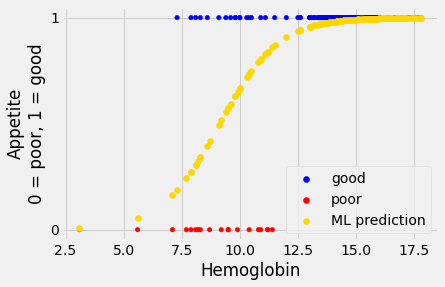

In [58]:
plot_hgb_app()
plt.scatter(hemoglobin, predicted_ML, c='gold', label='ML prediction')
plt.legend();

## A computation trick for the likelihood

As you have seen, the likelihood values can be, and often are, very small, and
close to zero.

You may also know that standard numerical calculations on computers are not
completely precise; the calculations are only accurate to around 16 decimal
places.  This is because of the way computers store floating point numbers.
You can find more detail in [this page on floating point
numbers](http://matthew-brett.github.io/teaching/floating_point.html).

The combination of small likelihood values, and limited calculation precision,
can be a problem for the simple ML logistic cost function you see above.  As a
result, practical implementations of logistic regression use an extra trick to
improve the calculation accuracy of the likelihoods.

This trick also involves logarithms.

Here we show a very important property of the logarithm transform:

In [59]:
print('Multiplying two numbers', 11 * 15)
print('Take logs, add logs, unlog', np.exp(np.log(11) + np.log(15)))

Multiplying two numbers 165
Take logs, add logs, unlog 165.00000000000009


What you see here is that we get (almost) the same answer if we:

* Multiply two numbers OR
* If we take the logs of the two numbers, *add them*, then reverse the log
  operation, in the this case with `np.exp`.

We get *almost* the same number because of the limitations of the precision of
the calculations.  For our cases, we do not need to worry about these tiny
differences.

The log-add-unlog trick means that we can replace multiplication by addition,
if we take the logs of the values.

Here we do the same trick on an array of numbers:

In [60]:
some_numbers = np.array([11, 15, 1, 0.3])
print('Product of the array', np.prod(some_numbers))
print('Log-add-unlog on the array', np.exp(np.sum(np.log(some_numbers))))

Product of the array 49.5
Log-add-unlog on the array 49.500000000000036


We can use this same trick to calculate our likelihood by adding logs instead
of multiplying the probabilities directly:

In [61]:
print('Likelihood with product of array', np.prod(pp_of_label))
# The log-add-unlog version.
logs_of_pp = np.log(pp_of_label)
log_likelihood = np.sum(logs_of_pp)
print('Likelihood with log-add-unlog', np.exp(log_likelihood))

Likelihood with product of array 1.463854029404182e-13
Likelihood with log-add-unlog 1.4638540294041883e-13


This doesn't seem to have solved all our problem, because we still end up with
the type of tiny number that confuses `minimize`.

The next stage of the solution is to realize that the `minimize` does not need
the *actual likelihood*, it needs some number that goes *up or down in exactly
the same way as likelihood*.  If the cost function can return some number that
goes up when likelihood goes up, and goes down when likelihood goes down,
`minimize` will still find the same parameters to minimize this cost function.

Specifically we want the value that comes back from the cost function to vary
[monotonically](https://en.wikipedia.org/wiki/Monotonic_function) with respect
to the likelihood.  Consider any two pairs of (intercept, slope). Call the
first pair `p1` and the second pair `p2`.  Say `p1` gives a likelihood value of
`L1` and `p2` gives a likelihood value of `L2`. Now say we've got another way
of calculating a value for `p1` and `p2`, and the corresponding values that
come back from the new calculation are `N1` and `N2`.  Remember `miminize` is
searching for the (intercept, slope) pair that gives the lowest value from the
cost function.  So, we can swap the new calculation into our cost function, and
get the same parameters back from `miminize`, as long as it is always true
that:

* when `L1 > L2` then `N1 > N2`;
* when `L1 < L2` then `N1 < N2`; and
* when `L1 == L2`, `N1 == N2`.

In that case we call our new calculation generating `N1` and `N2` *monotonic*
with respect to the original calculation generating `L1` and `L2`.  In our case
this original calculation is likelihood. The new monotonic calculation is the
*log likelihood*.

In the plot below, you can see it is true that when the likelihood goes up,
then the log of the likelihood will also go up, and vice versa, so the log the
likelihood *is* monotonic with respect to the likelihood, and we can use it
instead of the likelihood, in our cost function.

<ipython-input-62-e831d14c95fa>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(likelihood_values, np.log(likelihood_values))


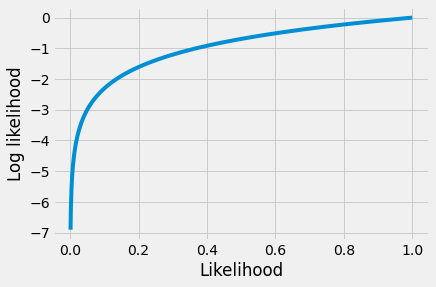

In [62]:
likelihood_values = np.linspace(0, 1, 1000)
plt.plot(likelihood_values, np.log(likelihood_values))
plt.xlabel('Likelihood')
plt.ylabel('Log likelihood');

This means that our cost function does not have to do the last nasty unlog step
above, that generates the tiny value for likelihood.  We can just return the
(minus of the) log of the likelihood.  The log of the likelihood turns out to
be a manageable negative number, even when the resulting likelihood is tiny.

In [63]:
log_likelihood

-29.552533505045645

This trick gives us a much more tractable number to return from the cost
function, because the log likelihood is much less affected by errors from lack
of precision in the calculation.

In [64]:
def mll_logit_cost(intercept_and_slope, x, y):
    """ Cost function for maximum log likelihood

    Return minus of the log of the likelihood.
    """
    intercept, slope = intercept_and_slope
    # Make predictions for sigmoid.
    predicted_log_odds = intercept + slope * x
    pp_of_1 = inv_logit(predicted_log_odds)
    # Calculate predicted probabilities of actual labels.
    pp_of_labels = y * pp_of_1 + (1 - y) * (1 - pp_of_1)
    # Use logs to calculate log of the likelihood
    log_likelihood = np.sum(np.log(pp_of_labels))
    # Ask minimize to find maximum by adding minus sign.
    return -log_likelihood

Use the new cost function:

In [65]:
mr_MLL = minimize(mll_logit_cost,  # Cost function
                  [-7, 0.8],  # Guessed intercept and slope
                  args=(hemoglobin, appetite_d),  # x and y values
                  )
# Show the result.
mr_MLL

      fun: 29.167993895856846
 hess_inv: array([[ 2.75031047, -0.2573524 ],
       [-0.2573524 ,  0.02512231]])
      jac: array([2.38418579e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([-7.29187319,  0.79915447])

Notice that we did not have to tell `minimize` to use a very small value for
the tolerance this time.

The values that come back are very similar to our previous, more fragile
version that used the likelihood:

In [66]:
inter_MLL, slope_MLL = mr_MLL.x
predicted_MLL = inv_logit(inter_MLL + slope_MLL * hemoglobin)

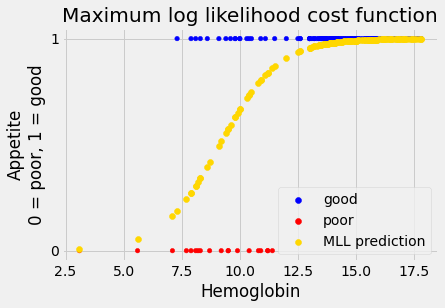

In [67]:
plot_hgb_app()
plt.scatter(hemoglobin, predicted_ML, c='gold', label='MLL prediction')
plt.title('Maximum log likelihood cost function')
plt.legend();

You have just seen the standard calculations behind most packages that
implement logistic regression.

To show this is standard, let us do the same regression in Statsmodels

## Logistic Regression with Statsmodes

As with linear regression, we can easily perform logistic regression using
Statsmodels.

In [68]:
# Get the formula interface for Statsmodels
import statsmodels.formula.api as smf

In [69]:
# Create the model.
log_reg_mod = smf.logit('appetite_dummy ~ Hemoglobin', data=hgb_app)
# Fit it.
fitted_log_reg_mod = log_reg_mod.fit()
fitted_log_reg_mod.summary()

Optimization terminated successfully.
         Current function value: 0.184608
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         appetite_dummy   No. Observations:                  158
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Apr 2021   Pseudo R-squ.:                  0.4976
Time:                        12:09:54   Log-Likelihood:                -29.168
converged:                       True   LL-Null:                       -58.054
Covariance Type:            nonrobust   LLR p-value:                 2.944e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.2919      1.659     -4.396      0.000     -10.543      -4.041
Hemoglobin     0.7992      0.158      5.042      0.000       0.489       1.110
==============================================================================
"""

Notice that Statsmodels lists the "Model" as "Logit" and the "Method" as "MLE"
— Maximum Likelihood Estimation.

Look at the table above under 'coef'. Compare the logistic regression intercept
and slope that Statsmodels found to the ones we got from `minimize` and the
maximum log likelihood (MLL) cost function.

In [70]:
print('Intercept from minimize =', inter_MLL)
print('Slope from minimize =', slope_MLL)

Intercept from minimize = -7.291873189544533
Slope from minimize = 0.7991544697361764


Finally, we can use the `predict` method of Statsmodels to generate predicted
probabilities from the logistic regression model we have just fitted:

In [71]:
sm_predictions = fitted_log_reg_mod.predict(hgb_app['Hemoglobin'])
sm_predictions.head()

0    0.840058
1    0.574466
2    0.792325
3    0.056433
4    0.242617
dtype: float64

Let us plot the predicted probabilities of having "good" appetite, from
Statsmodels:

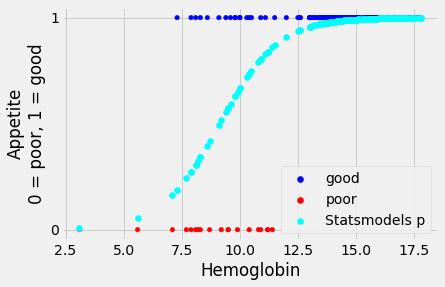

In [72]:
plot_hgb_app()
plt.scatter(hemoglobin, sm_predictions,
            label = 'Statsmodels p', color = 'cyan')
plt.legend();

We can see graphically that these predictions look identical to the ones we
obtained from minimize.

Let us see what the largest absolute difference between the predictions from
the two methods is:

In [73]:
np.max(np.abs(predicted_MLL - sm_predictions))

7.954712916147244e-08

That is very close to 0. The models are making almost identical predictions.

## Summary

This tutorial has shown you how to do binary logistic regression with one numerical predictor variable.


## Exercises for reflection

You might want to read the [logarithm refresher](logarithms_refreshed) page for
these questions.

* Consider the expression `np.exp(y)` in the `inv_logit` expression above.
  This means "raise `np.e` to the power of the values in `y`", and could
  equally well be written as `np.e ** y` (it would give exactly the same
  result).  Now consider changing `np.exp(y)` to `10 ** y`.  Now we are working
  in base 10 instead of base `np.e`.  What would happen to:

  * The best-fit p values predictions returned via `minimize`?
  * The slope and intercept of the best-fit log-odds straight line?

  Reflect, using the reasoning here, then try it and see.

* Consider the expression `np.sum(np.log(pp_of_labels))` in the
  `mll_logit_cost` cost function.  This is using `np.log`, which is log to the
  base `np.e`.  Consider what would happen if you change this expression to
  `np.sum(np.log10(pp_of_labels))` (log to the base 10).  What would happen to:

  * The best-fit p values predictions returned via `minimize`?
  * The slope and intercept of the best-fit log-odds straight line?

  Reflect, using the reasoning here, then try it and see.